## `Building makemore Part 3: MLP`

In [184]:
## import modules
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import torch.nn.functional as F

In [185]:
## Read the file
words = open('../makemore/names.txt', 'r').read().splitlines()
len(words)

32033

In [186]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(f'vocab_size = {vocab_size}')

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size = 27


In [187]:
block_size = 3 ## This means looking previous 3 words

'''
Building dataset
'''
def build_dataset(words):    
    X, Y = [], []

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)            
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [188]:
'''
Splitting dataset into train, validation and test set
'''
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


#### NLP Image
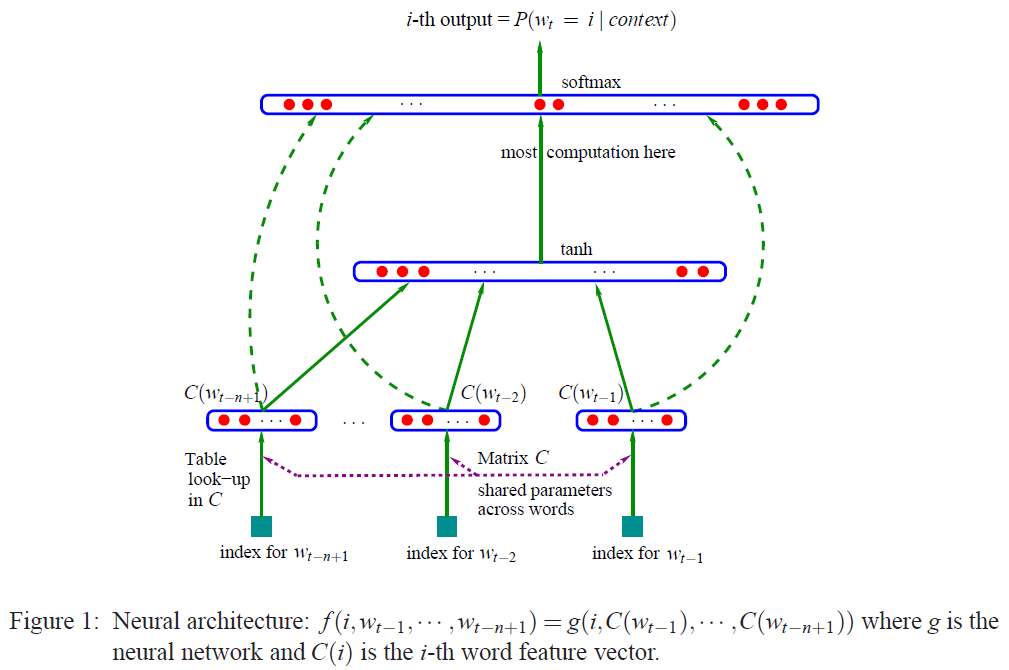

## Compiling all works

In [189]:
Xtr.shape, Ytr.shape, Xdev.shape, Ydev.shape, Xte.shape, Yte.shape 

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [190]:
g = torch.Generator().manual_seed(2147483647)

In [191]:
n_embd = 10 ## The dimensionality of character embedding vector
n_hidden = 200 ## The number of neurons in the hidden layer of the MLP

In [192]:
## torch.nn.init.kaiming_normal_
## std = gain/(fan_mode**0.5)
## https://pytorch.org/docs/stable/nn.init.html
std = (5/3)/((n_embd * block_size)**0.5) ## fan-in for W1 is 30

In [193]:
'''
Creating the embedding initialization into 2-D space
'''
C = torch.randn((vocab_size, n_embd), generator=g) 

'''
Constructing a hidden layer
'''
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * std
b1 = torch.randn(n_hidden, generator=g) * 0.01

'''
Constructing a final layer
'''
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 ## For having less loss at the beginning
b2 = torch.randn(vocab_size, generator=g) * 0 ## For having less loss at the beginning

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

'''
Total parameters
'''
print(f'Total parameters -> {sum(p.nelement() for p in parameters)}')

'''
Enabling gradient to True for all parameters
'''
for p in parameters:
    p.requires_grad = True

Total parameters -> 12297


tensor(0.0159) tensor(0.9938)
tensor(-0.0005) tensor(0.9729)


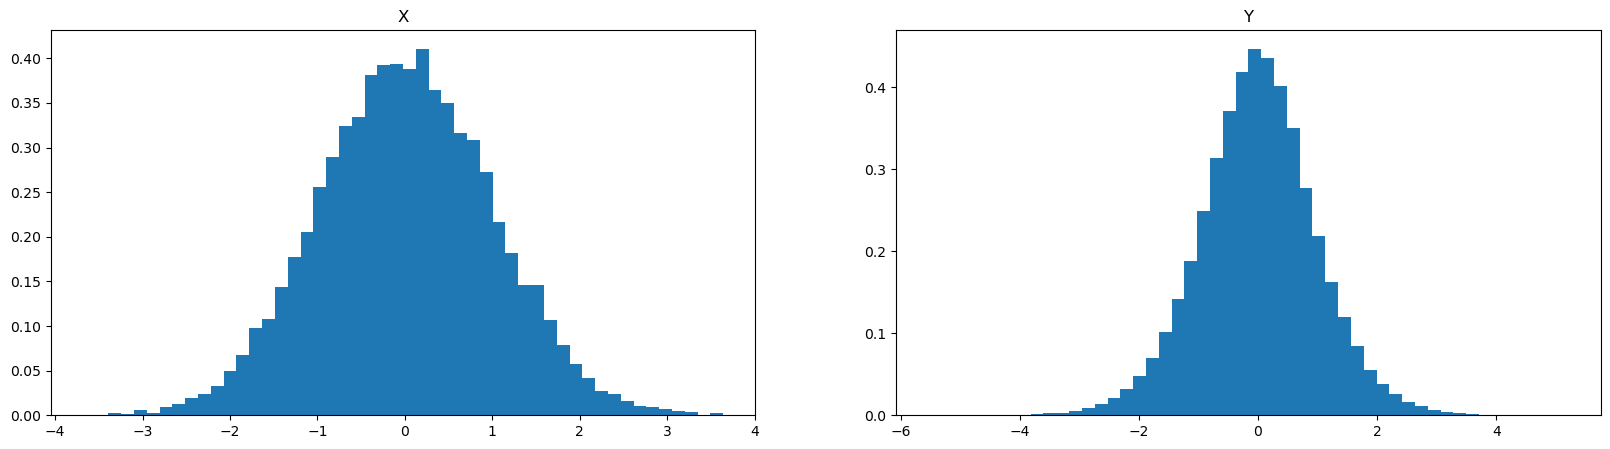

In [194]:
'''
Here we are finding a principled way of finding the magic number.
'''

## Lets motivate the discussion
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 ## The magic number is divided by sqrt(fan-in)
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))

plt.subplot(121)
plt.title("X")
plt.hist(x.view(-1).tolist(), 50, density=True);

plt.subplot(122)
plt.title("Y")
plt.hist(y.view(-1).tolist(), 50, density=True);

In [195]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ######################
    ## minibatch construct
    ######################
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] ## batch X, Y
    
    ################
    ## Forward Pass
    ################
    '''
    Embedding with shape 32 words (incl '.', context size, embedding space (2D))
    This mean, that 32 characters are embedded in 2D space with context size of 3
    '''
    emb = C[Xb] 
    embcat = emb.view(emb.shape[0], -1)    

    '''
    Hidden and final
    '''
    hpreact = embcat @ W1 + b1
    
    '''
    Apply Batch-Normalization formula from the original paper
    '''
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True) + bnbias
    #hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias ## Taking mean and std of the entire training set instead of batch
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias 
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi    
    
    '''
    Apply tanh activation
    '''
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2

    '''
    Loss function
    '''
    loss = F.cross_entropy(logits, Yb)

    ##################
    ## Backward Pass
    ##################
    for p in parameters:
        p.grad = None
    loss.backward()

    ###################
    ## Parameter update
    ###################    
    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad ## As per the chart, best lr should be around 0.1
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


## For finding the issues - DONOT TOUCH

In [ ]:
plt.hist(h.view(-1).tolist(), 50); ## This shows that most of the values are either -1 or +1

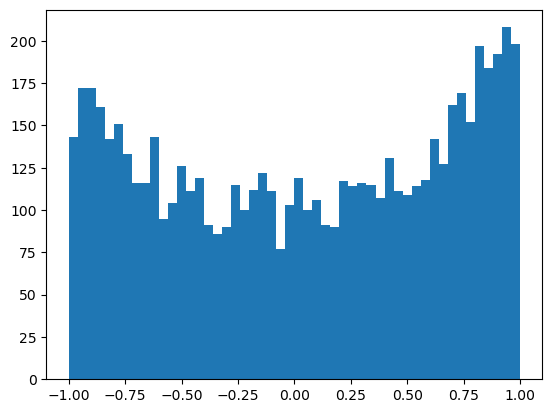

In [120]:
plt.hist(h.view(-1).tolist(), 50); ## Now spread is reduced

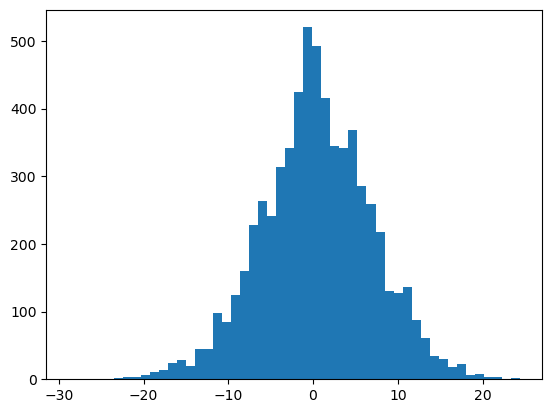

In [98]:
## Lets check preactivation
plt.hist(hpreact.view(-1).tolist(), 50);

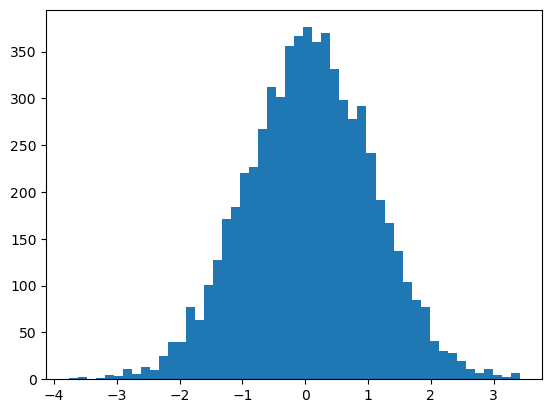

In [121]:
## Lets check preactivation post changes
plt.hist(hpreact.view(-1).tolist(), 50);

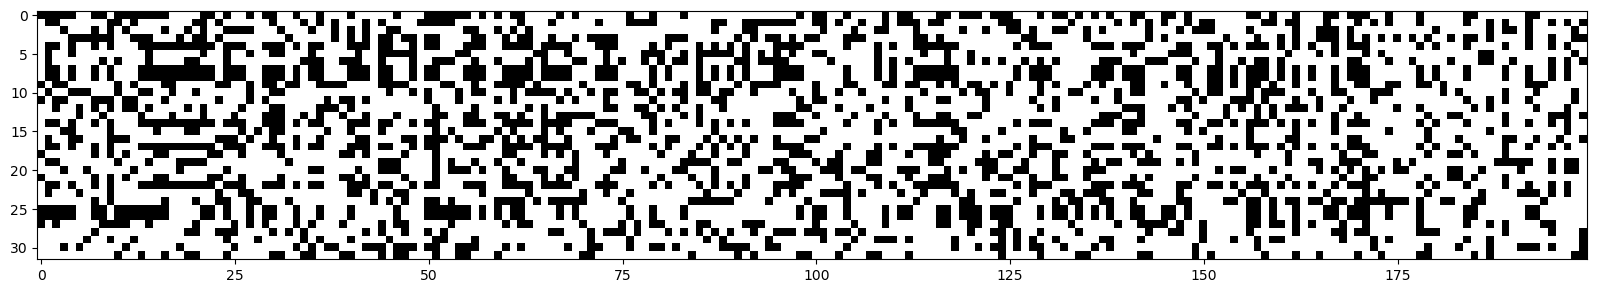

In [99]:
## pre-optimization - It shows how many neurons values are near to extreme values in tanh (i.e. -1, 1)
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

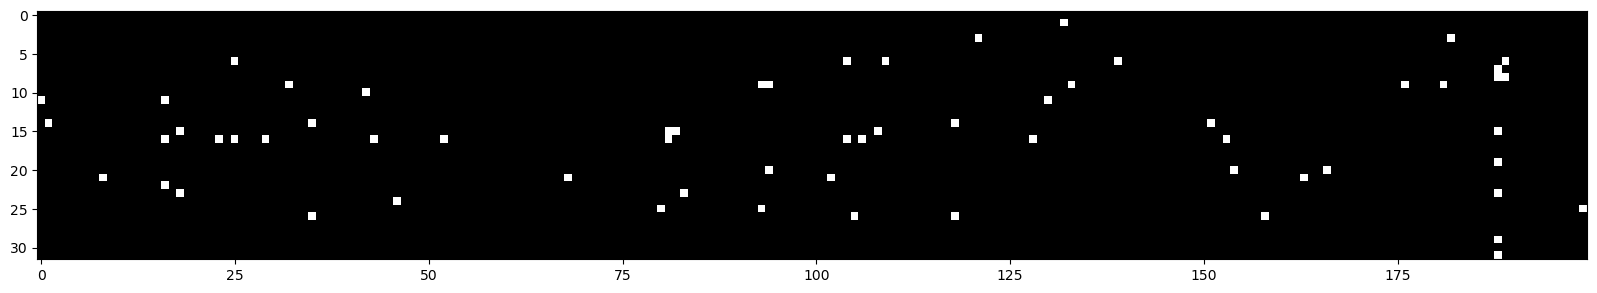

In [122]:
## post-optimization - It shows how many neurons values are near to extreme values in tanh (i.e. -1, 1)
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

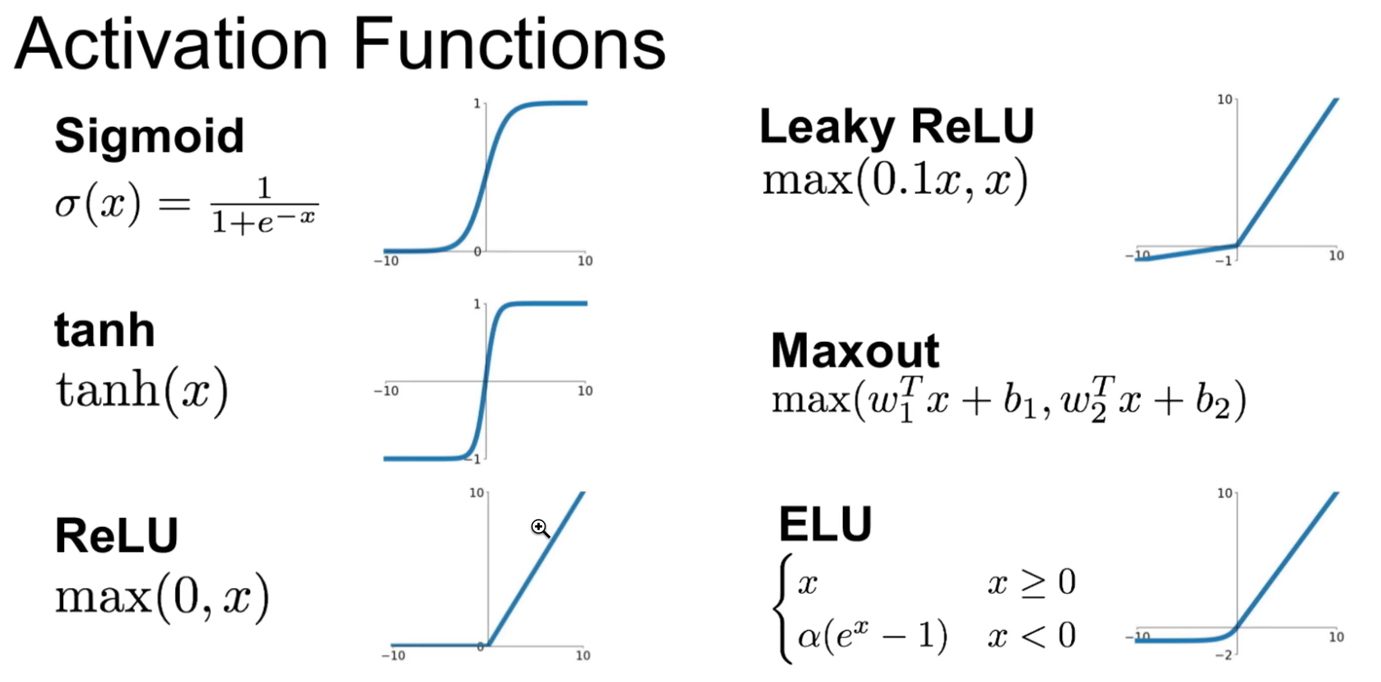

## End of experiment

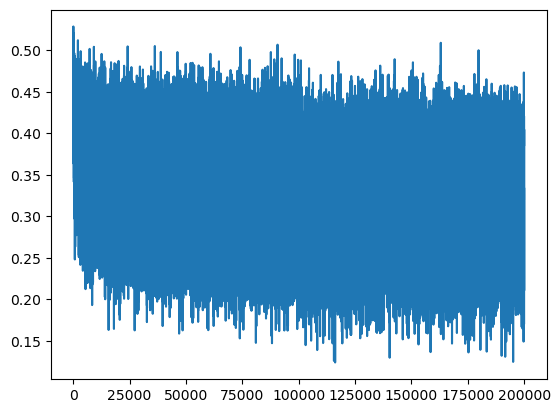

In [196]:
plt.plot(lossi)

In [197]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [198]:
split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.105057716369629


In [199]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [204]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


## Diagnostic Tools

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

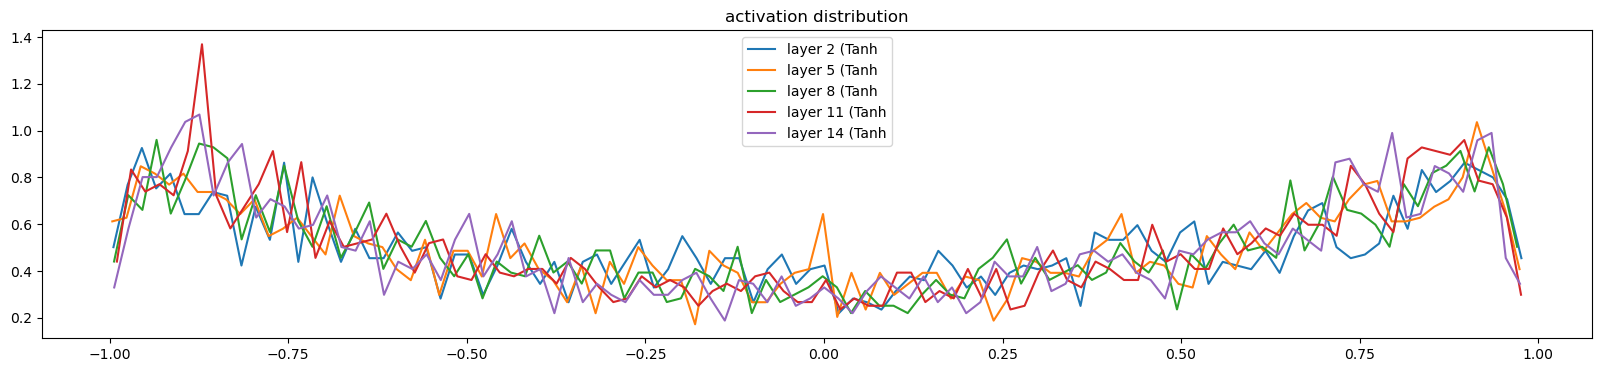

In [205]:
# visualize histograms
'''
Forward pass Activation Plot
'''
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.640701e-03
layer 5 (      Tanh): mean +0.000000, std 2.245583e-03
layer 8 (      Tanh): mean -0.000000, std 2.045741e-03
layer 11 (      Tanh): mean +0.000000, std 1.983132e-03
layer 14 (      Tanh): mean -0.000000, std 1.952381e-03


Text(0.5, 1.0, 'gradient distribution')

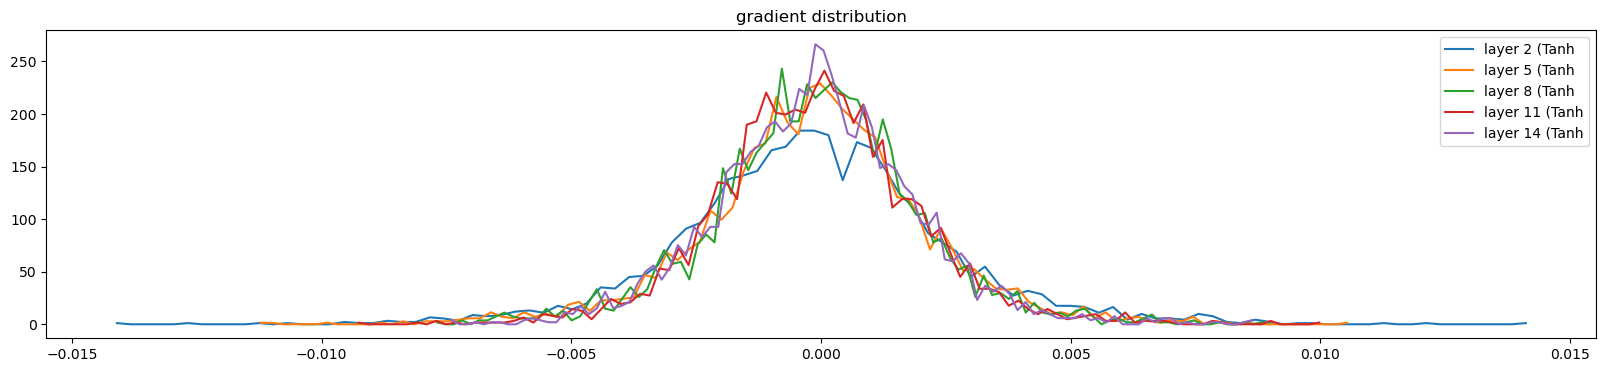

In [206]:
# visualize histograms
'''
Backward pass Gradient Plot
'''
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.020531e-03 | grad:data ratio 8.012627e-03
weight  (30, 100) | mean +0.000246 | std 9.241071e-03 | grad:data ratio 4.881088e-02
weight (100, 100) | mean +0.000113 | std 7.132874e-03 | grad:data ratio 6.964614e-02
weight (100, 100) | mean -0.000086 | std 6.234300e-03 | grad:data ratio 6.073736e-02
weight (100, 100) | mean +0.000052 | std 5.742180e-03 | grad:data ratio 5.631476e-02
weight (100, 100) | mean +0.000032 | std 5.672199e-03 | grad:data ratio 5.570120e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


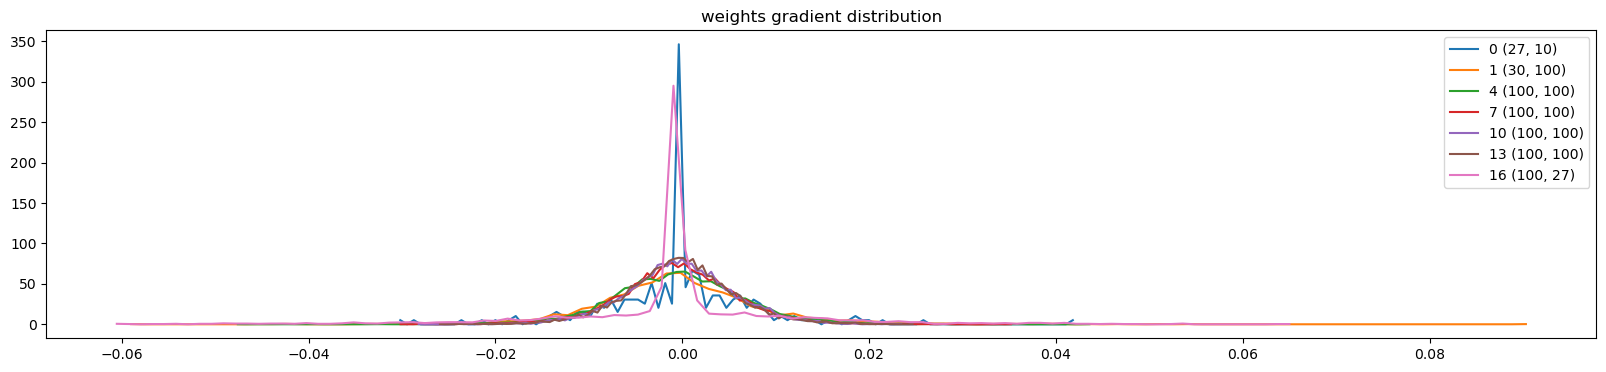

In [207]:
# visualize histograms
'''
Gradient-to-Data ratio Plot (weight updation)
'''
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

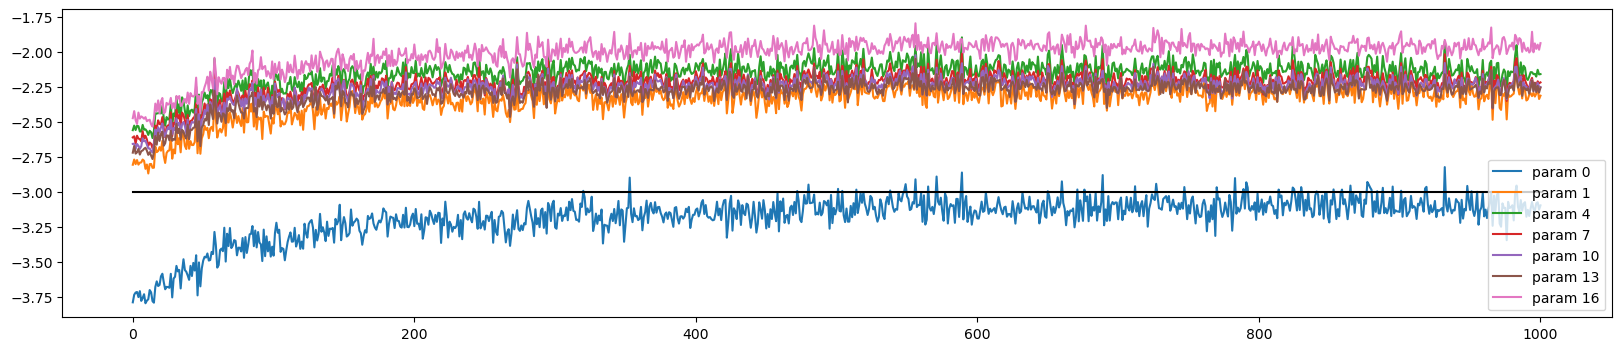

In [208]:
'''
Update to data ratio plot
'''
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


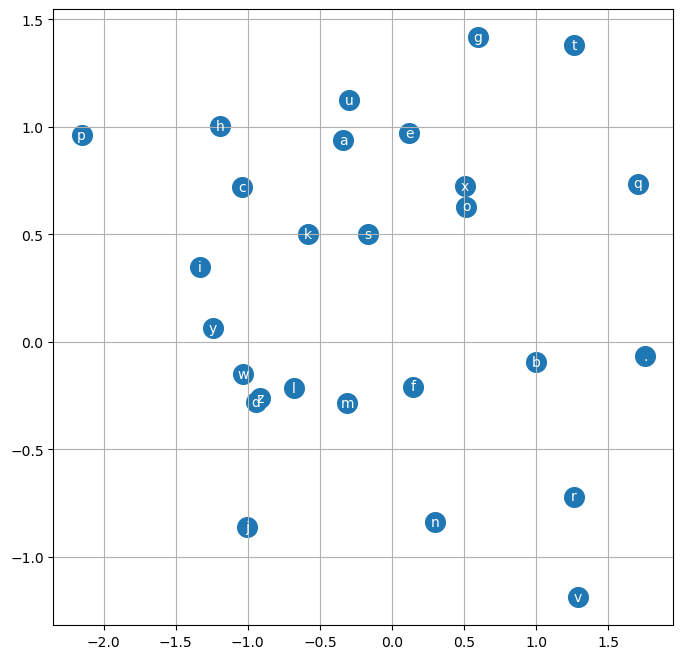

In [209]:
'''
Checking the trained word embeddings.
Note that the network learnt and hence there is a clustering of letters in the word embedding plot in 2D. 
e.g. vowels are clustered together
'''
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [210]:
'''
How to take sample from the model
'''
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() ## to get the next index
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))        

carpzveqtryll.
khztrrixhtttl.
sacausie.
rahntnfarlynraivaqgic.
raysia.
chmiir.
briefmadhlthn.
briqtgbths.
luverinnnbqhrrael.
gdharisimfrydenits.
bruy.
friia.
gtlechantsa.
azaimothj.
ksya.
saqqwiozelyzotrmiyra.
day.
dep.
sadluuo.
zoessa.


## Tips to improve the model

* Change `number of neurons` in the hidden layer.
* Change `the dimentionality` of the embeddings.
* Change the `number of character feeding in as a context` into this model.
* Change the details of the optimization
    * `Number of iteration`
    * `Learning rates`
    * `Batch size`
    * `Learning rate decay`
    

## Model scrutinization

* <b> The initialization of the tensors was incorrect. It is suppose to be equal at the beginning. But we have seen that randomly initialized logits can take a high number. Hence, one way is to reduce the weights.

`
logits = torch.randn(4)*10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss
`

* <b> Lets analyze the h (tanh)

`We saw that most of the neurons are activated at the extreme points of tanh. Hence, it is important to normalize the initialization. We went through the paper and pytorch documentation https://pytorch.org/docs/stable/nn.init.html to find out the initialization magic number.`

`std = gain/sqrt(fan-in)`

* <b> Batch-Normalization

` We also saw that x @ W increases the std deviation. Hence, in order to keep the std more or less constant specially during initialization, Google came up with a solution known as Batch-normalization, which basically normalize in mini-batch with the given formula.`

In [182]:
%history -g

 2/1:
## import modules
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
 2/2:
## Read the file
words = open('../makemore/names.txt', 'r').read().splitline()
 2/3:
## Read the file
words = open('../makemore/names.txt', 'r').read().splitlines()
 2/4: words[:10]
 2/5:
## finding word length
len(words)
 2/6: min(w), max(w) for w in words
 2/7: [min(w), max(w) for w in words]
 2/8: min(w for w in words), max(w for w in words)
 2/9: min(len(w) for w in words), max(len(w) for w in words)
2/10:
## Find out the occurence of a letter with next adjacent letter
for w in words[:10]
2/11:
## Find out the occurence of a letter with next adjacent letter
for w in words[:10]: print(w)
2/12:
## Find out the occurence of a letter with next adjacent letter
for w in words[:10]: print(list(w))
2/13:
for w in words[:10]:
    print(w, w[:1])
2/14:
for w in words[:10]:
    chrs = '<S>' + list(w) + '<E>'
    print(chrs)
2/15:
for w in words[:10]:
    chrs = ['<S>'] + list